In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score as ras
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

In [31]:
df = pd.read_csv('titanic/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [32]:
df.shape

(8693, 14)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [34]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [35]:
def compare_dataframe_info(df1, df2):
  """
  Compares the information of two DataFrames.

  Args:
    df1: The first DataFrame.
    df2: The second DataFrame.

  Returns:
    A dictionary of differences between the two DataFrames.
  """

  differences = {}

  # Compare the column names
  column_names1 = df1.columns
  column_names2 = df2.columns

  # Get the columns that are only in the first DataFrame
  df1_only_columns = list(set(column_names1) - set(column_names2))

  # Get the columns that are only in the second DataFrame
  df2_only_columns = list(set(column_names2) - set(column_names1))

  # Add the column names to the differences dictionary
  differences['column_names'] = {
      'df1_only': df1_only_columns,
      'df2_only': df2_only_columns
  }

  # Compare the data types
  data_types1 = df1.dtypes
  data_types2 = df2.dtypes

  # Get the columns where the data types are different
  different_data_types_columns = [
      column for column in set(column_names1) & set(column_names2)
      if data_types1[column] != data_types2[column]
  ]

  # Add the columns with different data types to the differences dictionary
  differences['data_types'] = {
      'different_data_types': different_data_types_columns
  }

  return differences


In [36]:
# Load the test data
test_data = pd.read_csv('titanic/test.csv')

In [37]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [38]:
test_data.shape

(4277, 13)

In [39]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [40]:
# checking the both training and testing dataframe 
# found that training only have Transported col additional that is perfect
print(compare_dataframe_info(df, test_data))

{'column_names': {'df1_only': ['Transported'], 'df2_only': []}, 'data_types': {'different_data_types': []}}


### checking null values

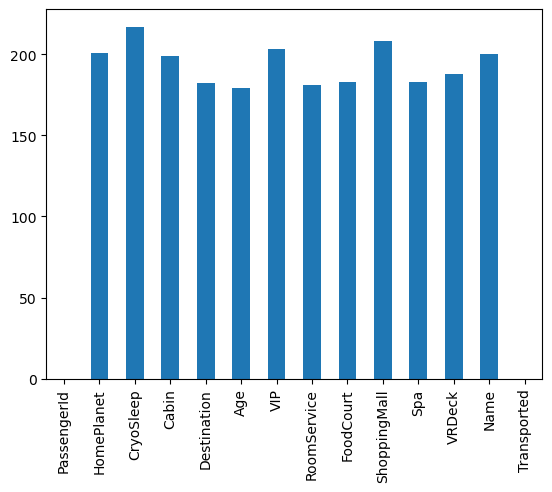

In [41]:
df.isnull().sum().plot.bar()
plt.show()

In [42]:
# col from RoomService to VRDeck
col = df.loc[:,'RoomService':'VRDeck'].columns
df.groupby('VIP')[col].mean()
df.groupby('VIP')[col].std()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
VIP,,,,,
False,644.922614,1505.278247,610.900749,1127.555366,1084.678230
True,1098.363713,3758.336442,587.449429,1622.153873,2453.060817


In [43]:
df.groupby('CryoSleep')[col].count()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
CryoSleep,,,,,
False,5328,5329,5335,5326,5320
True,2969,2967,2941,2972,2975


In [44]:
df.groupby('CryoSleep')[col].mean()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
CryoSleep,,,,,
False,350.146772,713.004316,270.586504,486.09294,475.716165
True,0.000000,0.000000,0.000000,0.00000,0.000000


In [45]:
df.groupby('CryoSleep')[col].std()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
CryoSleep,,,,,
False,803.08032,1970.547985,741.756155,1396.233751,1404.174304
True,0.00000,0.000000,0.000000,0.000000,0.000000


In [46]:
temp = df['CryoSleep'] == True
df.loc[temp, col] = 0.0

In [47]:
for c in col:
    for val in [True, False]:
        temp = df['VIP'] == val
        k = df[temp][c].mean()  # Calculate the mean for the specific column 'c'
        df.loc[temp, c] = df.loc[temp, c].fillna(str(k))  # Convert k to a string before filling NaN values


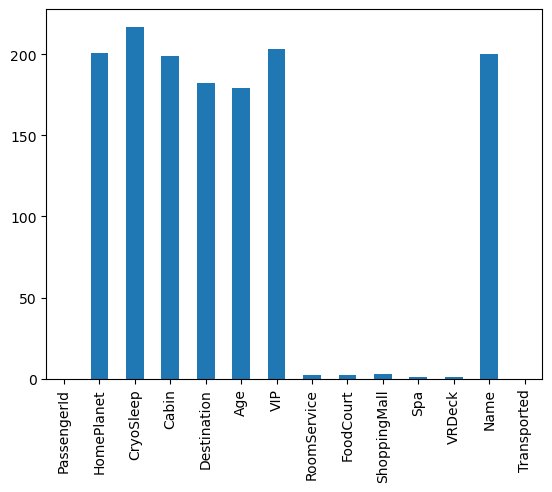

In [48]:
df.isnull().sum().plot.bar()
plt.show()

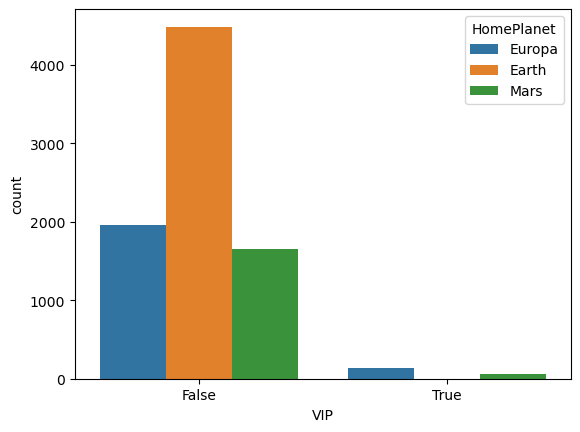

In [49]:
sns.countplot(data=df, x='VIP',
            hue='HomePlanet')
plt.show()


In [50]:
col = 'HomePlanet'
temp = df['VIP'] == False
df.loc[temp, col] = df.loc[temp, col].fillna('Earth')

temp = df['VIP'] == True
df.loc[temp, col] = df.loc[temp, col].fillna('Europa')


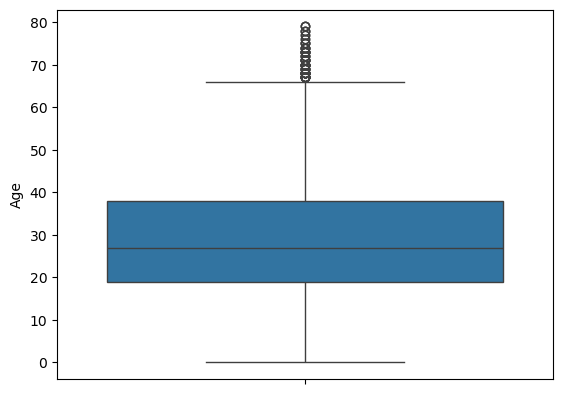

In [51]:
sns.boxplot(df['Age'])
plt.show()

In [52]:
temp = df[df['Age'] < 61]['Age'].mean()
df['Age'] = df['Age'].fillna(temp)


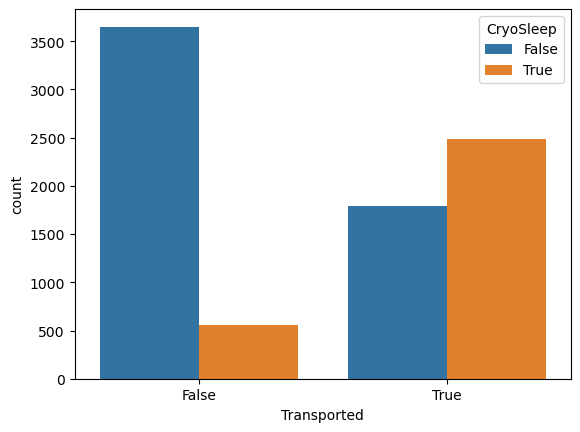

In [53]:
sns.countplot(data=df,
            x='Transported',
            hue='CryoSleep')
plt.show()


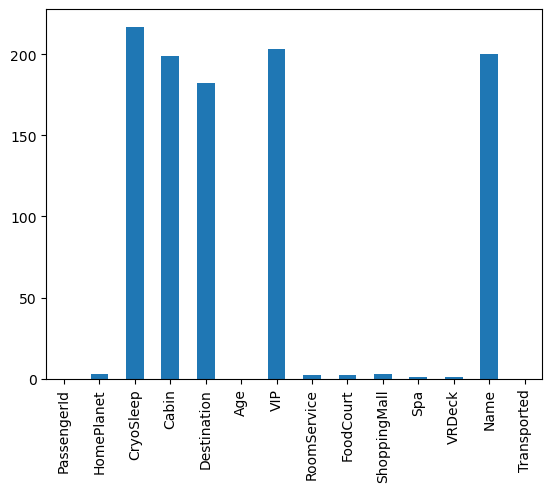

In [54]:
df.isnull().sum().plot.bar()
plt.show()


In [55]:
for col in df.columns:
    # Check for null values presence
    if df[col].isnull().sum() == 0:
        continue

    # If the data type is categorical filling by mode.
    if df[col].dtype == object or df[col].dtype == bool:
        df[col] = df[col].fillna(df[col].mode()[0])

    # Else by mean
    else:
        df[col] = df[col].fillna(df[col].mean())

df.isnull().sum().sum()


0

In [56]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [57]:
df.shape

(8693, 14)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   object 
 8   FoodCourt     8693 non-null   object 
 9   ShoppingMall  8693 non-null   object 
 10  Spa           8693 non-null   object 
 11  VRDeck        8693 non-null   object 
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(3), float64(1), object(10)
memory usage: 772.6+ KB


In [59]:
# new = df["PassengerId"].str.split("_", n=1, expand=True)
# df["RoomNo"] = new[0].astype(int)
# df["PassengerNo"] = new[1].astype(int)

# df.drop(['PassengerId', 'Name'],
#         axis=1, inplace=True)


In [60]:
# data = df['RoomNo']
# for i in range(df.shape[0]):
#     temp = data == data[i]
#     df['PassengerNo'][i] = (temp).sum()


In [61]:
# df.drop(['RoomNo'], axis=1,
#         inplace=True)

# sns.countplot(data=df,
#         x = 'PassengerNo',
#             hue='VIP')
# plt.show()


In [62]:
# new = df["Cabin"].str.split("/", n=2, expand=True)
# data["F1"] = new[0]
# df["F2"] = new[1].astype(int)
# df["F3"] = new[2]

# df.drop(['Cabin'], axis=1,
#         inplace=True)


In [63]:
# df['LeasureBill'] = df['RoomService'] + df['FoodCourt']\
# + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
# df.head()

In [64]:
# df['LeasureBill'] = df['RoomService'].astype(float) + df['FoodCourt'].astype(float) + \
# + df['ShoppingMall'].astype(float) + df['Spa'].astype(float) + df['VRDeck'].astype(float)

# df.head()

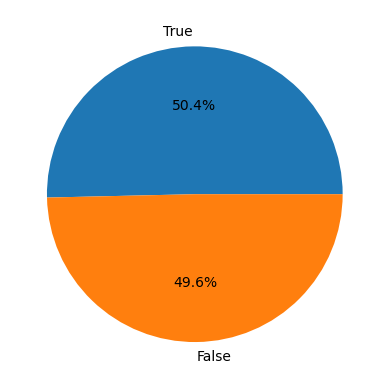

In [65]:
x = df['Transported'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   object 
 8   FoodCourt     8693 non-null   object 
 9   ShoppingMall  8693 non-null   object 
 10  Spa           8693 non-null   object 
 11  VRDeck        8693 non-null   object 
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(3), float64(1), object(10)
memory usage: 772.6+ KB


In [67]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [68]:
df['RoomService'] = df['RoomService'].astype(float)
df['FoodCourt'] = df['FoodCourt'].astype(float)
df['ShoppingMall'] = df['ShoppingMall'].astype(float)
df['Spa'] = df['Spa'].astype(float)
df['VRDeck'] = df['VRDeck'].astype(float)


In [69]:
# df.groupby('VIP').mean()['LeasureBill'].plot.bar()
# plt.show()


In [70]:
# import numpy as np

# # Replace non-numeric values with NaN
# df['LeasureBill'] = pd.to_numeric(df['LeasureBill'], errors='coerce')

# # Now, you can calculate the mean without errors
# mean_leasurebill = df.groupby('VIP')['LeasureBill'].mean()

# # Plot the mean values
# mean_leasurebill.plot.bar()
# plt.xlabel('VIP')
# plt.ylabel('Mean LeasureBill')
# plt.title('Mean LeasureBill by VIP')
# plt.show()


In [71]:
for col in df.columns:
    print(f"{df[col].name}: {df[col].dtype}")
    
    # encode them
    if df[col].dtype == object:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
  
    # In case of boolean data type 
    # convert them to binary
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)    

df.head()


PassengerId: object
HomePlanet: object
CryoSleep: bool
Cabin: object
Destination: object
Age: float64
VIP: bool
RoomService: float64
FoodCourt: float64
ShoppingMall: float64
Spa: float64
VRDeck: float64
Name: object
Transported: bool


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,1,0,149,2,39.0,0,0.0,0.0,0.0,0.0,0.0,5252,0
1,1,0,0,2184,2,24.0,0,109.0,9.0,25.0,549.0,44.0,4502,1
2,2,1,0,1,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,457,0
3,3,1,0,1,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,7149,0
4,4,0,0,2186,2,16.0,0,303.0,70.0,151.0,565.0,2.0,8319,1


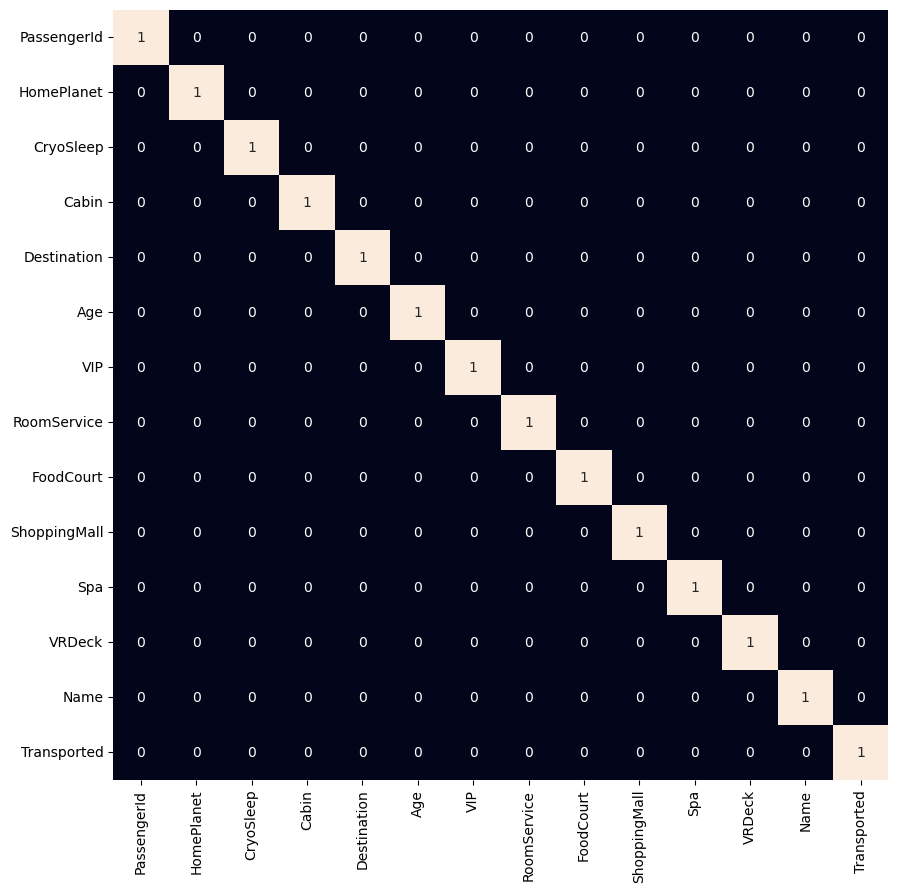

In [72]:
# display corellation only if it is more than 0.8
plt.figure(figsize=(10,10))
sns.heatmap(df.corr()>0.8,
        annot=True,
        cbar=False)
plt.show()


From the above heat map, we can see that there are no highly correlated features which implies we are good to go for our model development part.

In [73]:
features = df.drop(['Transported'], axis=1)
target = df.Transported

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                    test_size=0.1,
                                    random_state=22)

X_train.shape, X_val.shape


((7823, 13), (870, 13))

In [74]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7823 entries, 2410 to 6276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   7823 non-null   int64  
 1   HomePlanet    7823 non-null   int64  
 2   CryoSleep     7823 non-null   int64  
 3   Cabin         7823 non-null   int64  
 4   Destination   7823 non-null   int64  
 5   Age           7823 non-null   float64
 6   VIP           7823 non-null   int64  
 7   RoomService   7823 non-null   float64
 8   FoodCourt     7823 non-null   float64
 9   ShoppingMall  7823 non-null   float64
 10  Spa           7823 non-null   float64
 11  VRDeck        7823 non-null   float64
 12  Name          7823 non-null   int64  
dtypes: float64(6), int64(7)
memory usage: 855.6 KB


In [75]:
# scaled the data for easier and faster training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


LogisticRegression() : 
Training Accuracy :  0.8676852808111886
Validation Accuracy :  0.8528797642769321

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9874509883138124
Validation Accuracy :  0.8615418450841565

SVC(probability=True) : 
Training Accuracy :  0.8

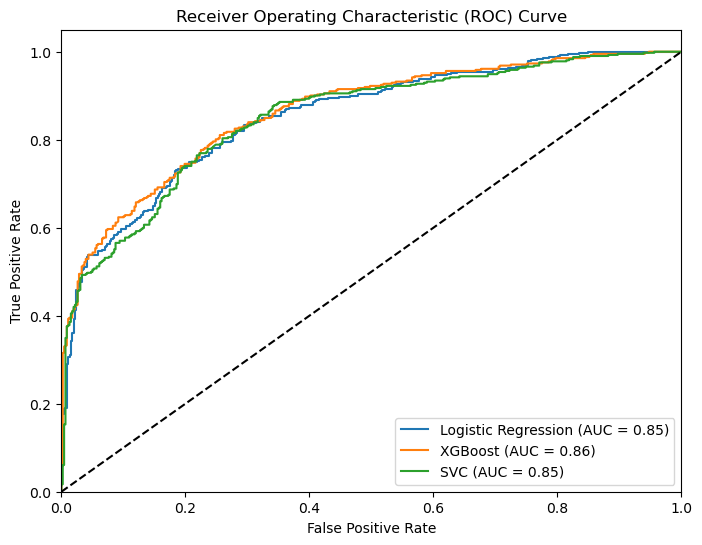

In [76]:
# taking all three models logisting regression, extreem gradient boosting, support vector machine
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]
model_names = ['Logistic Regression', 'XGBoost', 'SVC']

plt.figure(figsize=(8, 6))

for i in range(len(models)):
    models[i].fit(X_train, Y_train)

    train_preds = models[i].predict_proba(X_train)[:, 1]
    train_auc = ras(Y_train, train_preds)

    val_preds = models[i].predict_proba(X_val)[:, 1]
    val_auc = ras(Y_val, val_preds)

    fpr, tpr, _ = roc_curve(Y_val, val_preds)
    
    print(f'{models[i]} : ')
    print('Training Accuracy : ', ras(Y_train, train_preds))
    print('Validation Accuracy : ', ras(Y_val, val_preds))
    print()    

    plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {val_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [77]:
# # Create a threshold of 0.5
# threshold = 0.5

# # Convert Y_val to a binary variable
# Y_val_binary = np.where(Y_val > threshold, 1, 0)

<Figure size 1500x500 with 0 Axes>

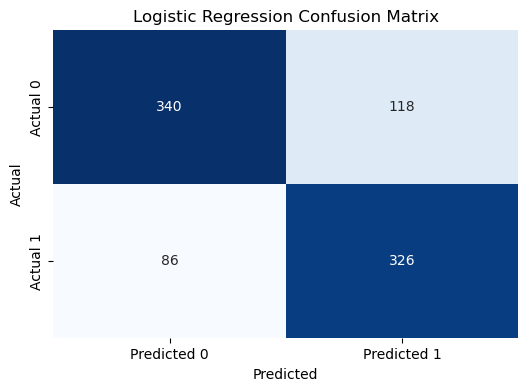

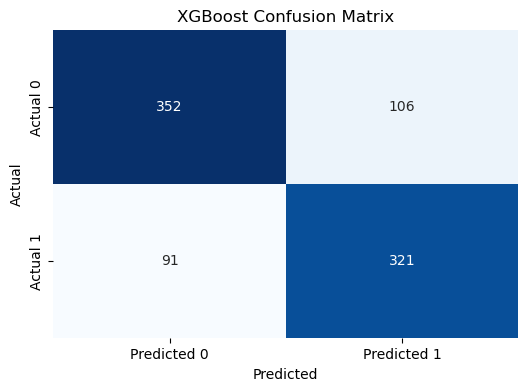

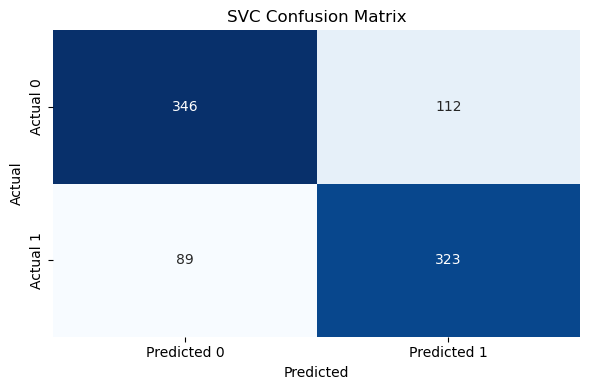

In [78]:
# Define the models and their names
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]
model_names = ['Logistic Regression', 'XGBoost', 'SVC']

# Create a figure to display the confusion matrices
plt.figure(figsize=(15, 5))

for i in range(len(models)):
    # Fit the model
    models[i].fit(X_train, Y_train)

    # Calculate ROC AUC for validation data
    val_preds = models[i].predict_proba(X_val)[:, 1]

    # Create a confusion matrix for validation data
    val_preds_binary = (val_preds > 0.5).astype(int)
    confusion = confusion_matrix(Y_val, val_preds_binary)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_names[i]} Confusion Matrix')

plt.tight_layout()
plt.show()

### Load the test data

In [79]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [80]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


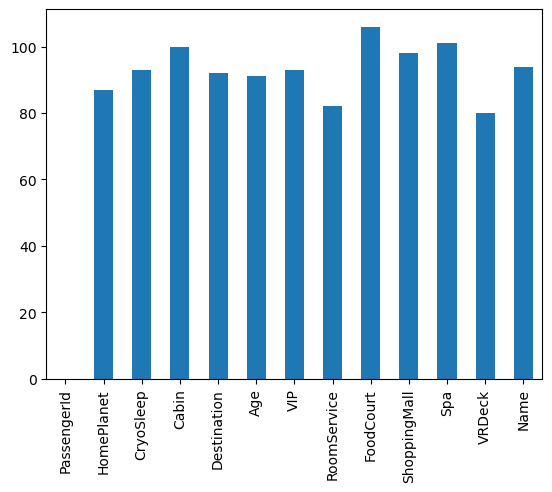

In [81]:
test_data.isnull().sum().plot.bar()
plt.show()

In [82]:
# col from RoomService to VRDeck
col = test_data.loc[:,'PassengerId':'VRDeck'].columns
test_data.groupby('VIP')[col].mean()
test_data.groupby('VIP')[col].std()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
VIP,,,,,,
False,14.238827,601.572488,1382.339825,563.196941,1011.130129,1179.272861
True,9.771106,950.751255,3148.189863,538.606825,3094.997904,2724.361469


In [83]:
test_data.groupby('CryoSleep')[col].count()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
CryoSleep,,,,,,,,,,,,
False,2640,2584,2640,2578,2583,2583,2578,2584,2573,2579,2583,2590
True,1544,1516,1544,1509,1512,1512,1515,1519,1505,1509,1502,1515


In [84]:
for col in test_data.columns:
    # Check for null values presence
    if test_data[col].isnull().sum() == 0:
        continue

    # If the data type is categorical filling by mode.
    if test_data[col].dtype == object or test_data[col].dtype == bool:
        test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

    # Else by mean
    else:
        test_data[col] = test_data[col].fillna(test_data[col].mean())

test_data.isnull().sum().sum()


0

In [85]:
# Handle missing values (you can use different strategies)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
test_data['RoomService'].fillna(0, inplace=True)  # Replace missing values with 0 for numerical columns

# Encode categorical features using LabelEncoder or one-hot encoding
label_encoder = LabelEncoder()

# Example: Encoding 'HomePlanet' using LabelEncoder
test_data['HomePlanet'] = label_encoder.fit_transform(test_data['HomePlanet'])

# Example: Encoding 'CryoSleep' using LabelEncoder
test_data['CryoSleep'] = label_encoder.fit_transform(test_data['CryoSleep'])

test_data['RoomService'] = test_data['RoomService'].astype(float)
test_data['FoodCourt'] = test_data['FoodCourt'].astype(float)
test_data['ShoppingMall'] = test_data['ShoppingMall'].astype(float)
test_data['Spa'] = test_data['Spa'].astype(float)
test_data['VRDeck'] = test_data['VRDeck'].astype(float)

for col in test_data.columns:
    print(f"{test_data[col].name}: {test_data[col].dtype}")
    
    # encode them
    if test_data[col].dtype == object:
        le = LabelEncoder()
        test_data[col] = le.fit_transform(test_data[col])
  
    # In case of boolean data type 
    # convert them to binary
    if test_data[col].dtype == 'bool':
        test_data[col] = test_data[col].astype(int)    

test_data.head()


PassengerId: object
HomePlanet: int64
CryoSleep: int64
Cabin: object
Destination: object
Age: float64
VIP: bool
RoomService: float64
FoodCourt: float64
ShoppingMall: float64
Spa: float64
VRDeck: float64
Name: object


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0,0,1,2784,2,27.0,0,0.0,0.0,0.0,0.0,0.0,2912
1,1,0,0,1867,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,2406
2,2,1,1,257,0,31.0,0,0.0,0.0,0.0,0.0,0.0,3376
3,3,1,0,259,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2711
4,4,0,0,1940,2,20.0,0,10.0,0.0,635.0,0.0,0.0,668


## Compare Different Models performance

Shape of X_val: (870, 13)
Shape of predictions: (870,)
Shape of X_val: (870, 13)
Shape of predictions: (870,)
Shape of X_val: (870, 13)
Shape of predictions: (870,)


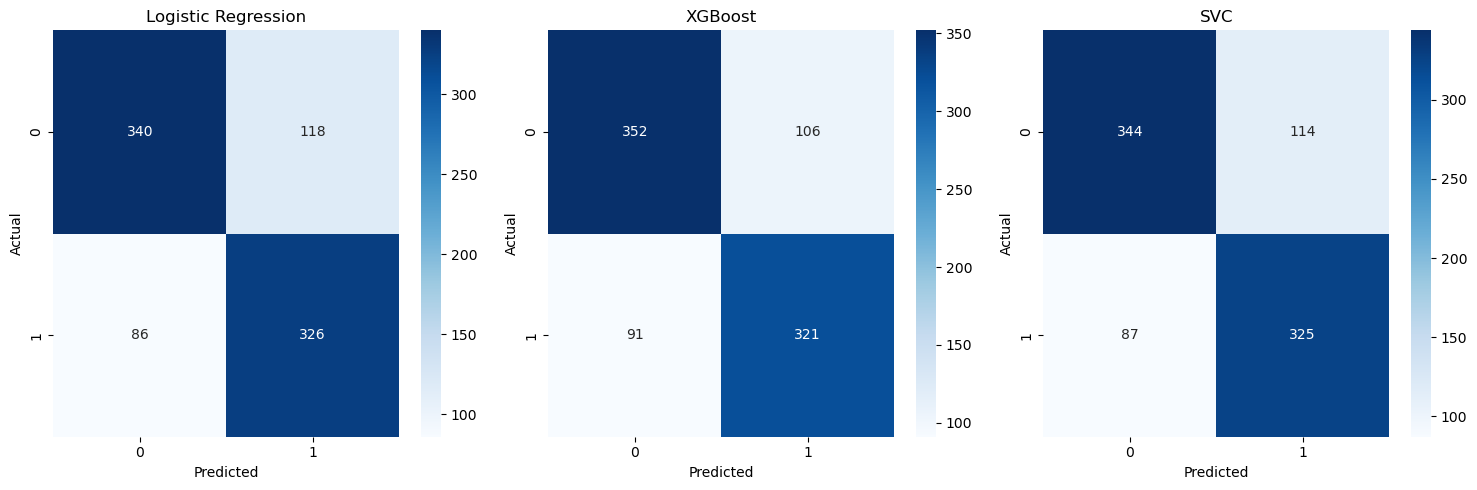

In [95]:
# Define the models and their names
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]
model_names = ['Logistic Regression', 'XGBoost', 'SVC']

# Create a figure to display the confusion matrices
plt.figure(figsize=(15, 5))

for i in range(len(models)):
    # Fit the model
    models[i].fit(X_train, Y_train)


    # Make predictions on validation data
    predictions = models[i].predict(X_val)  # Use X_val for validation

    # Check shapes (optional)
    print(f"Shape of X_val: {X_val.shape}")
    print(f"Shape of predictions: {predictions.shape}")

    # Ensure shapes match (if necessary)
    if X_val.shape[0] != predictions.shape[0]:
        # Reshape if needed (example assuming X_val has extra dimension)
        X_val = X_val.reshape(-1, features)  # Replace features with your actual number of features

    # Calculate confusion matrix
    cm = confusion_matrix(Y_val, predictions)

    # Create a subplot for the confusion matrix
    plt.subplot(1, len(models), i + 1)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.title(model_names[i])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()
    
#     # Create a DataFrame for submission
#     submission_df = pd.DataFrame({
#         'PassengerId': test_data['PassengerId'],  # Use the PassengerId from the test data
#         'Survived': predictions  # Replace 'Survived' with the actual column name for predictions
#     })
